In [1]:
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys
import pickle 
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import corner

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

import sys, platform, os
from numpy import sqrt, sin, cos, pi
import scipy.constants as cst

camb_path = os.path.realpath(os.path.join(os.getcwd(),'..'))
sys.path.insert(0,camb_path)
import camb
from camb import model, initialpower

In [2]:
import scipy.integrate as integrate
import scipy.special as special     
from scipy.interpolate import CubicSpline
from scipy import interpolate
from scipy.optimize import curve_fit
from scipy.integrate import quad, dblquad

In [3]:
train_params = np.load('LHS_params_3dim.npz')   

In [5]:
print(train_params.files)                                       # Each of the keys has an 'np.array' of values

['h', 'omega_b', 'omega_cdm']


In [6]:
#print(train_params['omega_b'])

n_samples = len(train_params['h'])
print('number of training samples: ', len(train_params['omega_b'])) 

number of training samples:  1400


In [7]:
cosmo_params = np.zeros((len(train_params['omega_b']), 3))
print(cosmo_params[199])

cosmo_params[:, 0] = train_params['h']
cosmo_params[:, 1] = train_params['omega_b']
cosmo_params[:, 2] = train_params['omega_cdm']
#cosmo_params[:, 3] = train_params['ns']
#cosmo_params[:, 4] = train_params['z']
#cosmo_params[:, 5] = train_params['lnAs']
#cosmo_params[:, 6] = train_params['w']

[0. 0. 0.]


In [8]:
print(cosmo_params[0])
print(cosmo_params[199])

[0.577198   0.02702287 0.12390994]
[0.7494639  0.02219085 0.1689421 ]


In [9]:
#kh = []
#pk= []

def camb_cosmo(i):
    
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=100*cosmo_params[i, 0], ombh2=cosmo_params[i, 1], omch2=cosmo_params[i, 2])
    pars.InitPower.set_params(As = 2e-9, ns=0.965)
    pars.set_matter_power(redshifts=[0.0], kmax=10.0)
    pars.set_dark_energy(w=-1.0, wa=0, dark_energy_model='fluid')

    # Linear spectra
    pars.NonLinear = model.NonLinear_none
    results = camb.get_results(pars)
    camb_kh, z, camb_pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=15, npoints=400)
    s8 = np.array(results.get_sigma8())      
    # s8 is the amplitude of matter fluctuations, i.e. in term of the average r.m.s fluctuation in a sphere of 8h^{−1}Mpc
    
    #kh.append(camb_kh)
    #pk.append(camb_pk)
    
#     plt.figure(figsize = (10,8))
#     plt.loglog(camb_kh, camb_pk[0], 'r')
#     #plt.plot(, r_array, 'ro')
#     plt.title('Matter Power Spectrum at z=0.0')
#     plt.rc('axes', labelsize=18)
#     plt.rc('axes', titlesize=16)
#     plt.rcParams['xtick.labelsize']=14
#     plt.rcParams['ytick.labelsize']=14
#     plt.xlabel(r'$k\,[h\,\mathrm{Mpc}^{-1}]$')
#     plt.ylabel(r'$\mathrm{P}(k)\, [(h^{-1}\mathrm{Mpc})^{3}]$')
#     #plt.legend(['linear'], loc='lower left', fontsize=14);
#     plt.grid(alpha=0.2)
#     plt.tick_params(top=True,right=True, length=6)
#     plt.show()
    
    return camb_kh, camb_pk[0] 
    
    
cosmo_func = camb_cosmo(0)                                                   #calculates the m.p.s of 1st sample out of 200
#print(cosmo_func[1])
#print(pk[0])

Epoch 1/100
14/14 - 0s - loss: 0.9549 - 440ms/epoch - 31ms/step
Epoch 2/100
14/14 - 0s - loss: 0.9281 - 16ms/epoch - 1ms/step
Epoch 3/100
14/14 - 0s - loss: 0.8716 - 32ms/epoch - 2ms/step
Epoch 4/100
14/14 - 0s - loss: 0.7813 - 24ms/epoch - 2ms/step
Epoch 5/100
14/14 - 0s - loss: 0.6615 - 24ms/epoch - 2ms/step
Epoch 6/100
14/14 - 0s - loss: 0.5169 - 24ms/epoch - 2ms/step
Epoch 7/100
14/14 - 0s - loss: 0.3841 - 16ms/epoch - 1ms/step
Epoch 8/100
14/14 - 0s - loss: 0.2843 - 16ms/epoch - 1ms/step
Epoch 9/100
14/14 - 0s - loss: 0.2183 - 24ms/epoch - 2ms/step
Epoch 10/100
14/14 - 0s - loss: 0.1801 - 16ms/epoch - 1ms/step
Epoch 11/100
14/14 - 0s - loss: 0.1550 - 16ms/epoch - 1ms/step
Epoch 12/100
14/14 - 0s - loss: 0.1349 - 24ms/epoch - 2ms/step
Epoch 13/100
14/14 - 0s - loss: 0.1203 - 16ms/epoch - 1ms/step
Epoch 14/100
14/14 - 0s - loss: 0.1054 - 24ms/epoch - 2ms/step
Epoch 15/100
14/14 - 0s - loss: 0.0910 - 16ms/epoch - 1ms/step
Epoch 16/100
14/14 - 0s - loss: 0.0782 - 16ms/epoch - 1ms/step

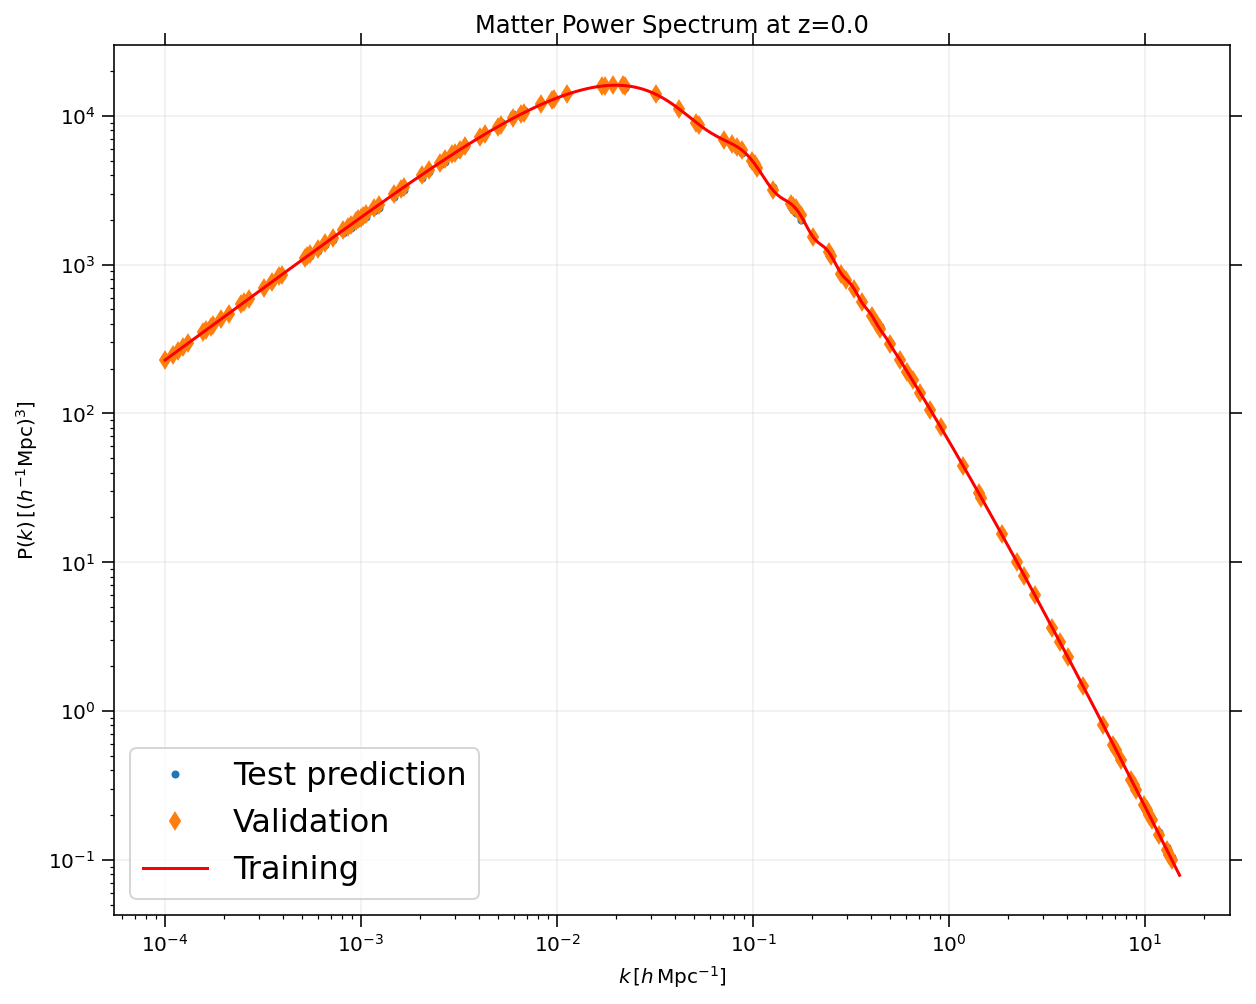

In [10]:
## TESTING (ANN for computing many cosmologies (for n_samples)):

# Generate power spectra:
cosmo_func = camb_cosmo(0)
    
train_k = cosmo_func[0]                                                             
train_pk = cosmo_func[1]    

# Standardising:

train_k_scaler = StandardScaler()
train_pk_scaler = StandardScaler()

# Storing the fit object for later reference
scaled_train_k = train_k_scaler.fit(np.log(train_k).reshape(-1,1)) 
scaled_train_pk = train_pk_scaler.fit(np.log(train_pk).reshape(-1,1))

# Generating the standardized values of X and y
X=scaled_train_k.transform(np.log(train_k).reshape(-1,1))
y=scaled_train_pk.transform(np.log(train_pk).reshape(-1,1))

# Split the data into training and testing set


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) 

# initializing the internal random number generator, setting random_state a fixed value will guarantee that
# same sequence of random numbers are generated each time you run the code.

# sort in ascending order:

zipped_lists = zip(X_train, y_train)
sorted_pairs = sorted(zipped_lists)

tuples = zip(*sorted_pairs)
X_train, y_train = [list(tuple) for tuple in  tuples]

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

#Building the NN:

tf_model = Sequential()
# Defining the first layer of the model
tf_model.add(Dense(units=32, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
 
# Defining the Second layer of the model
tf_model.add(Dense(units=32, kernel_initializer='normal', activation='relu'))
 
# The output neuron is a single fully connected node 
# Since we will be predicting a single number
tf_model.add(Dense(1, kernel_initializer='normal'))
 
# Compiling the model
tf_model.compile(loss='mean_squared_error', optimizer='adam')
 
# Fitting the ANN to the Training set
tf_model.fit(X_train, y_train, batch_size = 20, epochs = 100, verbose=2)
            
# Mean absolute percentage error
MAPE = np.mean(np.abs((y_test - tf_model.predict(X_test))/y_test))*100
# printing the results of the current iteration
#print(TrialNumber, 'Parameters:','batch_size:', batch_size_trial,'-', 'epochs:',epochs_trial, 'Accuracy:', 100-MAPE)
print('Accuracy:', 100-MAPE)


# Scaling the X data back to original scale
temp = X_train
temp2 = X_test

y_train_pred = scaled_train_pk.inverse_transform(tf_model.predict(temp))
y_test_pred = scaled_train_pk.inverse_transform(tf_model.predict(temp2))

X_train = scaled_train_k.inverse_transform(X_train)
X_test = scaled_train_k.inverse_transform(X_test)

# Scaling the y_test/train Price data back to original scale
y_train = scaled_train_pk.inverse_transform(y_train)
y_test = scaled_train_pk.inverse_transform(y_test)
    
# Scaling the test data back to original scale
#Test_Data = scaled_train_k.inverse_transform(X_test)

#Return to log scale:
X_train = np.exp(X_train)
y_train = np.exp(y_train)
X_test = np.exp(X_test)
y_test = np.exp(y_test)
prediction_train = np.exp(y_train_pred)
prediction_test = np.exp(y_test_pred)

plt.figure(figsize = (10,8))                                             ###DONE!
plt.loglog(X_test, prediction_test, "C0.")         #blue line
plt.loglog(X_test, y_test, "C1d")
plt.loglog(train_k, train_pk, 'r')
plt.title('Matter Power Spectrum at z=0.0')
plt.rc('axes', labelsize=18)
plt.rc('axes', titlesize=16)
plt.rcParams['xtick.labelsize']=14
plt.rcParams['ytick.labelsize']=14
plt.xlabel(r'$k\,[h\,\mathrm{Mpc}^{-1}]$')
plt.ylabel(r'$\mathrm{P}(k)\, [(h^{-1}\mathrm{Mpc})^{3}]$')
plt.legend(['Test prediction','Validation', 'Training'], loc='lower left', fontsize=16);
plt.grid(alpha=0.2)
plt.tick_params(top=True,right=True, length=6)
plt.show()

# #residual plot
# ax[1].set_ylabel(r'$\frac{\Delta \mathrm{P}(k)}{\mathrm{P}(k)}$')
# ax[1].loglog(train_k, ((prediction_train-train_pk)/train_pk), 'r', linestyle="dashdot")  #
# #plt.loglog(kh, pk[0], 'C0', linestyle="dashed")   
# #ax[1].loglog(kh, ((y_test-train_pk)/train_pk), 'C0')
# ax[1].set_yscale('linear')
# fig.tight_layout()
# plt.savefig('power_spectrum_H0.pdf')
# plt.show()

In [11]:
print(np.shape(train_k))
print(np.shape(train_pk))
print(np.shape(prediction_train))

(400,)
(400,)
(280, 1)


In [12]:
len(train_params['h'])

1400

In [13]:
%%time      #41 mins
## Training input params:
h = cosmo_params[:, 0]
# ombh2:
omega_b = cosmo_params[:, 1]
# omch2:
omega_c = cosmo_params[:, 2]

#Obtain pk matrix for output training param:
pk_matrix = []                                    #np.zeros((len(train_params['h']), np.shape(train_params)[0])) 
#print(pk_matrix[199][2])



for i in range(len(train_params['h'])):
               cosmo_func = camb_cosmo(i)
               pk_matrix.append(cosmo_func[1])

Wall time: 41min 53s


In [14]:
with open('pk_data.pkl', 'wb') as f:
    pickle.dump(pk_matrix, f)

In [15]:
with open('pk_data.pkl', 'rb') as f:
    pk_matrix = pickle.load(f)

In [17]:
print(np.shape(pk_matrix))

(1400, 400)
